In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

RANDOM_STATE = 42

import warnings
warnings.filterwarnings("ignore")

In [32]:
#Load the raw data
df = pd.read_csv("../data/raw/Telco-Customer-Churn.csv")

#Display the first five rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
#Remove the ID column
df = df.drop(columns=["customerID"])

In [34]:
#Fix TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].isna().sum()

np.int64(11)

In [35]:
#Drop missing rows
df = df.dropna(subset=["TotalCharges"]).copy()

In [36]:
# Target -> 1/0
y = (df["Churn"] == "Yes").astype(int)
X = df.drop(columns=["Churn"])

X.shape, y.shape

((7032, 19), (7032,))

In [37]:
#Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

y_train.mean(), y_test.mean()


(np.float64(0.2657777777777778), np.float64(0.2658137882018479))

In [38]:
#Preprocessing pipeline
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [39]:
#Utility: evaluate a fitted pipeline
def evaluate_pipeline(model_name: str, pipe: Pipeline):
    y_pred = pipe.predict(X_test)

    #Probability scores for ROC-AUC
    if hasattr(pipe, "predict_proba"):
        y_score = pipe.predict_proba(X_test)[:, 1]
    else:
        #Fallback: decision_function
        y_score = pipe.decision_function(X_test)

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_score)

    print(f"{model_name} -> F1: {f1:.4f} | ROC-AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return {"Model": model_name, "F1": f1, "ROC_AUC": auc}

Logistic Regression -> F1: 0.6069 | ROC-AUC: 0.8351


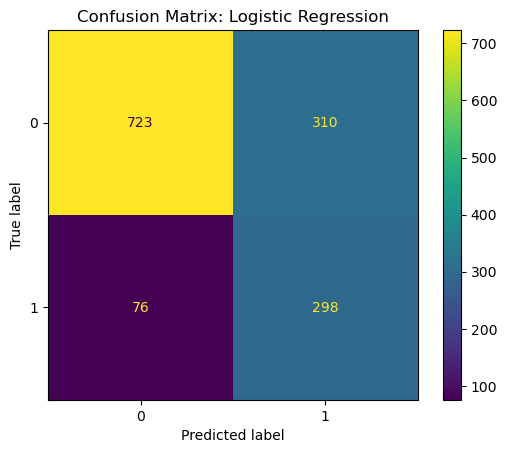

{'Model': 'Logistic Regression',
 'F1': 0.6069246435845214,
 'ROC_AUC': 0.8350930005021457}

In [40]:
#Model 1: Logistic Regression (baseline)
logreg = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)

logreg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", logreg),
])

logreg_pipe.fit(X_train, y_train)
r1 = evaluate_pipeline("Logistic Regression", logreg_pipe)
r1

Random Forest -> F1: 0.5432 | ROC-AUC: 0.8155


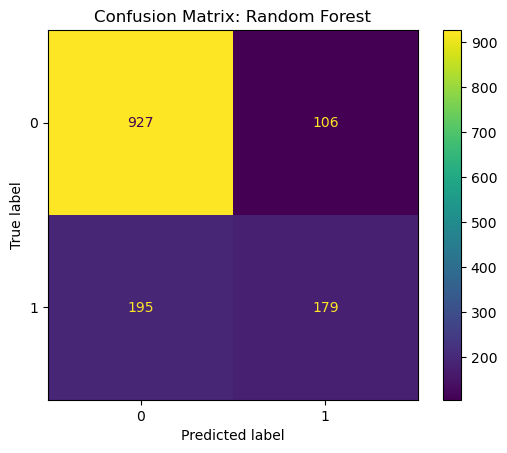

{'Model': 'Random Forest',
 'F1': 0.543247344461305,
 'ROC_AUC': 0.8154704898768449}

In [41]:
#Model 2: Random Forest (stronger baseline)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])

rf_pipe.fit(X_train, y_train)
r2 = evaluate_pipeline("Random Forest", rf_pipe)
r2

In [42]:
#Results table (paste into README later)
results = pd.DataFrame([r1, r2]).sort_values(by="ROC_AUC", ascending=False)
results

,Model,F1,ROC_AUC
0,Logistic Regression,0.606925,0.835093
1,Random Forest,0.543247,0.815470


In [43]:
#Choose best model (by ROC-AUC; you can switch to F1 if you prefer)
best_name = results.iloc[0]["Model"]
best_pipe = rf_pipe if best_name == "Random Forest" else logreg_pipe
best_name

'Logistic Regression'

In [44]:
#Save the best trained pipeline (includes preprocessing)
import joblib
import os

os.makedirs("../models", exist_ok=True)
joblib.dump(best_pipe, "../models/churn_model_pipeline.joblib")
print("Saved:", "../models/churn_model_pipeline.joblib")


Saved: ../models/churn_model_pipeline.joblib


In [45]:
#Quick sanity prediction on a few rows
sample = X_test.iloc[:5].copy()
pred_proba = best_pipe.predict_proba(sample)[:, 1]
pd.DataFrame({"churn_probability": pred_proba})


,churn_probability
0,0.050761
1,0.785200
2,0.014230
3,0.401228
4,0.231603


According to the obtained results, the best model is the logistic regression model because it wins on both F1 and ROC-AUC.